In [1]:
# Adrian Sinclair 2023
import numpy as np
import matplotlib.pyplot as plt

# find frequency shift of resonator from multiplication method

# resonator parameters from BLAST-TNG in-flight
# 350um Qr = 36380 Qc = 58290 Qi = 109808 
# 250um Qr = 14085 Qc = 71355 Qi = 18693
# 500um Qr = 8881 Qc = 91638 Qi = 10347

#350um
Qr = 36380 
Qc = 58290
Qi = 109808
f0_orig = 800e6 #Hz

# s-domain transfer function of shunted LRC resonator
# S21(s) =  (s^2 + w0/Qi*s + w0^2 )/ (s^2 + (w0/Qi + 2w0/Qc)*s + w0^2)
# let b = w0/Qi + 2w0/Qc and c = w0^2
# roots = +/- 1/2*sqrt(b^2 - 4*c) - b/2
w0 = f0_orig*2.*np.pi
b = w0/Qi + 2*w0/Qc
c = w0**2
print(np.sqrt(abs(b**2-4*c))/2.)
print(-b/2.)

# 500um 
#Qr = 8881 
#Qc = 91638
#f0 = 540e6 # Hz

# Generate true resonant frequency times series
N_quiescent = 10000
N_modulated = 10000
N = N_quiescent + N_modulated
k = np.linspace( 0, N_quiescent - 1 , N_quiescent)
n = np.linspace( 0, N -1, N)
df = 2e3 # Hz maximum displacement from original resonant frequency
#mod = np.arctan(np.linspace(-10,10,N))/np.pi*2*df
mod = np.concatenate((np.zeros(N//2) + f0_orig, np.ones(N//2)*df + f0_orig))
f0oft = mod - mod[0] + f0_orig

# add frequency noise
mu, sigma = 0, 400. # mean and standard deviation [Hz]
s = np.random.normal(mu, sigma, N)
f0oft = f0oft + s

# filter to limit frequency shifts to realistic detector bandwidth ~ 10kHz
f3dB = 10e3 # Hz
Ntaps = int(np.round(500e3/f3dB/2.))
fnew = np.copy(f0oft)
for i in range(np.size(f0oft)):
    fnew[i] = np.sum(f0oft[ i : i + Ntaps ])/Ntaps


def S21(f,f0,phi=0,A=1):
  return (1.0 - Qr/Qc*(1+2*1j*Qr*(f-f0)/f0)**(-1))*np.exp(1j*phi)*A

def measS21(f_input, n):
    """
    f_input: estimated resonator frequency from tracking circuit
    n: simulation sample index
    """
    return S21(f_input,f0oft[n])

def estimatef0( S21new, phi_ref):
    """
    S21new: latest complex transmission measurement
    phi_ref: reference phase to compare new phase and calculate error [rad]
    returns: df_calc the frequency error [Hz]
    """
    # calculate phase error
    phi_error = phi_ref - np.arctan2(S21new.imag,S21new.real) # compare to the latest value
    # proportional
    Kp = 500 #5e3 # Hz/rad
    # integral
    Ki = 50 #1e3 #1e3 # Hz/rad
    # derivative
    Kd = -10  #-10 # Hz/rad
    # sum together
    df_calc = Kp*phi_error[-1] + Ki*np.mean(phi_error) + Kd*(phi_error[-2]-phi_error[-1])
    
    return df_calc, phi_error[-1]

f_guesses = []
phi_error = []
df_corr = []
f_guess = f0_orig #+1e3
S21initial = measS21(f_guess,0)
phi_ref = 0#np.angle(S21initial)
L = 100 # length of integration filter in samples
S21t = np.zeros(N,dtype="complex")
# Add delay from measurment to control
for m in range(N-L):
    S21t[ m + L ] = measS21(f_guess, m + L )
    df, phi_err = estimatef0(S21t[ m : m+L ],phi_ref)
    phi_error.append(phi_err)
    df_corr.append(df)
    f_guess = f_guess + df 
    f_guesses.append(f_guess)
f_guesses = np.concatenate((np.ones(L)*f0_orig,np.array(f_guesses)))

5026548244.559211
-109121.35399271248


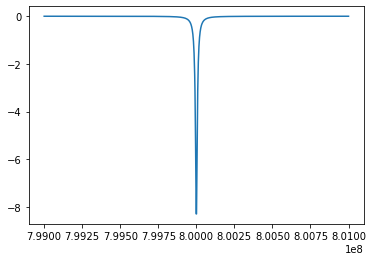

In [2]:
plt.figure()
f_list = np.linspace(f0_orig-1e6,f0_orig+1e6,1000)
plt.plot(f_list, 20.*np.log10( np.abs(S21(f_list,f0_orig,phi=0,A=1))))

<IPython.core.display.Javascript object>


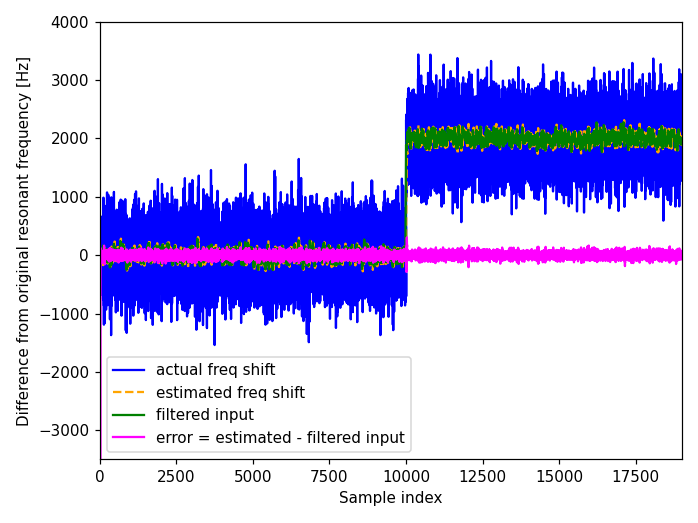

In [3]:
%matplotlib notebook
plt.figure()
#plt.plot(n,f0oft - f_guesses)
plt.plot(n,f0oft - f0_orig, color='blue',label='actual freq shift')
plt.plot(n,f_guesses - f0_orig,'--',color='orange', label='estimated freq shift')
#plt.plot(n,f_guesses - f0oft,'--',color='black',alpha=0.5, label='error = estimated - actual ')
plt.plot(n,fnew - f0_orig,color='green',label='filtered input')
plt.plot(n,(np.roll(fnew,24) - f0_orig) - (f_guesses - f0_orig),color='magenta', label = "error = estimated - filtered input")
plt.ylabel("Difference from original resonant frequency [Hz]")
plt.xlabel("Sample index")
plt.legend()
plt.xlim(0,19000)
plt.ylim(-3.5e3,4e3)
plt.tight_layout()